# $Volatlity:$ $Implied,$ $Skew,$ $Surface.$


A loud Italian option trader was known to start singing "volare, volare," an Italian popular song, every time the market experienced a panic,
to the great annoyance of his peers. When asked for the reason (by the angry author) he explained that volatility came from the Latin volare, which means "to fly."

-- Taleb, Dynamic Hedging

In [1]:
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt

import OptionLib
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Now lets implement implied volatility computations, referring to BSM and vega functions for better visibility:

In [2]:
def d1(r, spot, strike, time, sigma):
    return (np.log(spot / strike) + (r + sigma ** 2 / 2) * time) / (sigma * np.sqrt(time))


def d2(r, spot, strike, time, sigma):
    return d1(r, spot, strike, time, sigma) - sigma * np.sqrt(time)


def BSM(r, spot, strike, time, sigma, type='call'):
    """
    Returns Black-Scholes-Merton Price of and Call/Put option
    """
    try:
        d1_value = d1(r, spot, strike, time, sigma)
        d2_value = d2(r, spot, strike, time, sigma)

        if type == 'call':
            bsm_price = spot * norm.cdf(d1_value, 0, 1) - strike * np.exp(-r * time) * norm.cdf(d2_value, 0, 1)
        elif type == 'put':
            bsm_price = strike * np.exp(-r * time) * norm.cdf(-d2_value, 0, 1) - spot * norm.cdf(-d1_value, 0, 1)

        return bsm_price

    except:
        raise Exception('Standard_Error_Output')


def vega(r, spot, strike, time, sigma):
    """
    Returns Vega greek of an option given
    """
    d1_value = d1(r, spot, strike, time, sigma)

    try:
        vega_value = spot * norm.pdf(d1_value, 0, 1) * np.sqrt(time)
        return vega_value * 0.01
    except:
        raise Exception('Standard_Error_Output')

# Let's implement Volatility of European Option using Newton-Raphson method

In [3]:
def imp_vol(market_price, spot, strike, time, r, type, precision=1.0e-5, iterations=200):

    """
        Return Implied Volatility of European Option using Newton Raphson method,
        knowing standard parameters with addition of error tolerance and number of iterations.
        And choosing sigma to estimate:
    """

    sigma = 0.5
    for i in range(iterations):

        price = BSM(r, spot, strike, time, sigma, type)

        vega_v = vega(r, spot, strike, time, sigma) * 100

        diff = market_price - price

        if abs(diff) < precision:
            return sigma

        sigma = sigma + diff/vega_v

    return sigma # Best guess


In [4]:
spot = 100
strike = 100
time = 11
r = 0.0001
vol = 0.00001
type = 'call'
market_price = 66
market_bsm_value = BSM(r, spot, strike, time, vol, type)

print(imp_vol(market_price, spot, strike, time, r, type))
print(imp_vol(market_bsm_value, spot, strike, time, r, type))

0.5751604313310898
0.00010317646885598187


Notice that the 1-st result (using given real market price) conflict with 0.00001 which is umber form YahooFinance:
JPM230217C00070000, 2023-01-04 ... $0.00001$, ... USD.
This might happen since we had an arbitrary $r$.

However, the 2-nd one (using BSM price) provides higher accuracy estimation.

# Graphs:

Extracting data:

In [5]:
jpm = OptionLib.yf_get_chains('JPM')
jpm.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expDate,daysToExp
0,JPM230203C00100000,2023-01-03 19:38:02+00:00,100.0,34.05,38.80,39.00,0.0,0.0,100.0,0,2.718753,True,REGULAR,USD,call,2023-02-03 23:59:59,1
1,JPM230203C00105000,2023-01-03 18:15:30+00:00,105.0,29.37,33.60,34.25,0.0,0.0,1.0,0,3.054690,True,REGULAR,USD,call,2023-02-03 23:59:59,1
2,JPM230203C00110000,2023-02-02 16:27:29+00:00,110.0,29.74,0.00,0.00,0.0,0.0,10.0,0,0.000010,True,REGULAR,USD,call,2023-02-03 23:59:59,1
3,JPM230203C00115000,2022-12-30 17:53:27+00:00,115.0,19.00,25.15,25.60,0.0,0.0,6.0,0,3.248049,True,REGULAR,USD,call,2023-02-03 23:59:59,1
4,JPM230203C00117000,2023-01-27 16:08:18+00:00,117.0,22.90,0.00,0.00,0.0,0.0,7.0,0,0.000010,True,REGULAR,USD,call,2023-02-03 23:59:59,1


In [6]:
# Extracting Calls only
jpm_calls = jpm[jpm.optionType == 'call']
len(set(jpm_calls.expDate))

14

So we extracted only call-type option from whole range on JPM, and looked how many different expiration dates it has.

# Drawing Volatility Skew

Let's pick a date (the latest one) and get rid of low volatility options, by establishing a threshold.

In [7]:
date = '2023-03-17'
threshold = 0.001

In [8]:
jpm_calls_date = jpm_calls[jpm_calls["expDate"] == f"{date} 23:59:59".format(date)]

<AxesSubplot:title={'center':'Implied Volatility Skew'}, xlabel='strike'>

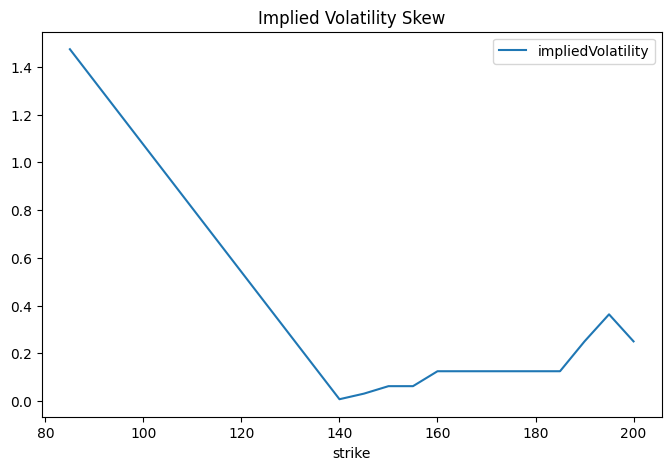

In [9]:
jpm_calls_date_ = jpm_calls_date[jpm_calls_date.impliedVolatility >= threshold]

jpm_calls_date_[["strike", "impliedVolatility"]].set_index("strike").plot(title="Implied Volatility Skew", figsize=(8, 5))


In [10]:
# Option with the highest volatility
print(sorted(jpm_calls_date.impliedVolatility)[-1])

1.4733913049316407


In [11]:
# this happens to be an option bellow:
# last JPM close - 139.59
jpm_calls_date.iloc[[6]]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expDate,daysToExp
6,JPM230317C00085000,2022-12-14 18:57:08+00:00,85.0,50.71,58.3,59.05,0.0,0.0,4.0,0,1.473391,True,REGULAR,USD,call,2023-03-17 23:59:59,43


Pay attention to the shape of the curve it's not that smooth, and part of this might be a computational algorithms for the implied volatility. In practise quants use their own models for better results.

Now let's transform it to the function.

In [12]:
def plot_iv_skew(date, threshold, df):
    """
    :param date: string in format of YYYY-MM-DD
    :param threshold: a criterion of low volatility filtration
    :param df: Options dataframe
    :return: plots a graph of Implied Volatility Skew
    """

    df_date = df[df["expDate"] == f'{date} 23:59:59'.format(date)]
    df_date_ = df_date[df_date.impliedVolatility >= threshold]

    df_date_[["strike", "impliedVolatility"]].set_index("strike").plot(title="Implied Volatility Skew", figsize=(8, 5))

# Volatility Term Structure

Similar to the Skew

In [13]:
# Strike picking
strike_value = jpm_calls['strike'].value_counts().idxmax()
strike_value

155.0

<AxesSubplot:title={'center':'Implied Volatility Term Structure'}, xlabel='expDate'>

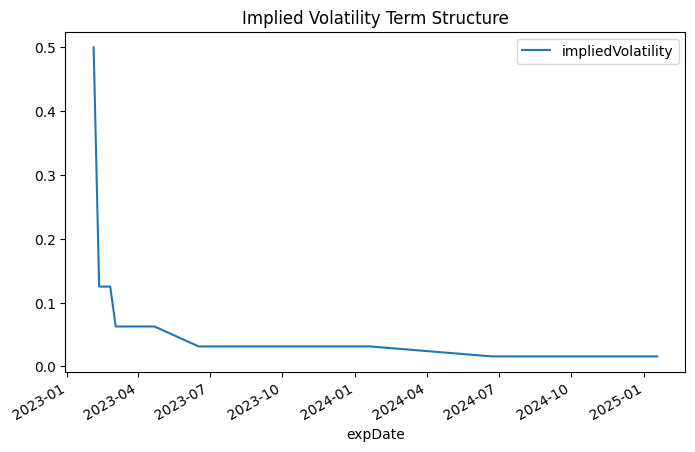

In [14]:
jpm_calls_strike = jpm_calls[jpm_calls["strike"] == strike_value]
jpm_calls_strike_ = jpm_calls_strike[jpm_calls_strike.impliedVolatility >= threshold] # as mentioned before threshold 0.001

jpm_calls_strike_[["expDate", "impliedVolatility"]].set_index("expDate").plot(title="Implied Volatility Term Structure", figsize=(8, 5))

In [15]:
def plot_iv_term(strike_value, threshold, df):
    """
    :param strike_value: value of a strike
    :param threshold: a criterion of low volatility filtration
    :param df: Options dataframe
    :return: plots a graph of Implied Volatility Term Structure
    """

    df_strike = df[df["strike"] == strike_value]
    df_strike_ = df_strike[df_strike.impliedVolatility >= threshold]

    df_strike_[["expDate", "impliedVolatility"]].set_index("expDate").plot(title="Implied Volatility Term Structure", figsize=(8, 5))

# Volatility Surface

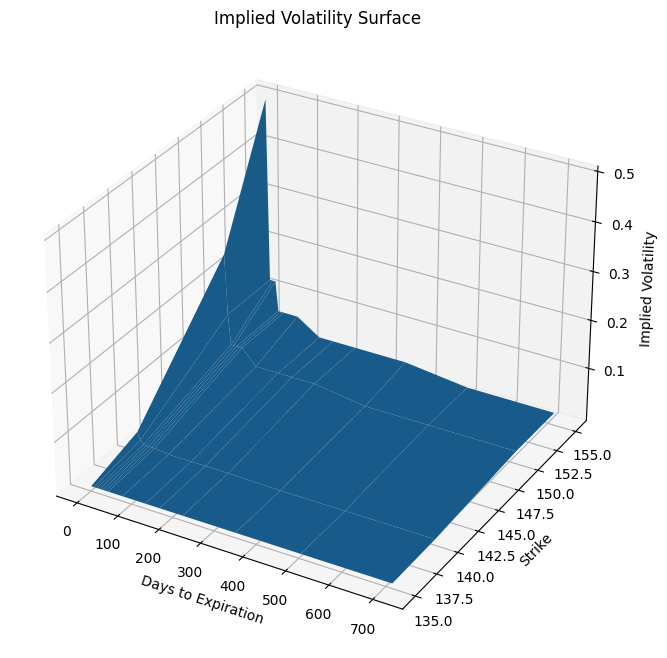

In [16]:
def plot_iv_surface(df):
    """
    :param df: Options Chains Dataframe
    :return: Plots a Graph of Implied Volatility Surface
    """

    vol_surface = (df[['daysToExp', 'strike', 'impliedVolatility']].pivot_table(
        values='impliedVolatility', index='strike', columns='daysToExp').dropna())

    plot = plt.figure(figsize=(8, 8))
    ax = plot.add_subplot(111, projection='3d')

    x, y, z = vol_surface.columns.values, vol_surface.index.values, vol_surface.values
    X, Y = np.meshgrid(x, y)

    ax.set_xlabel('Days to Expiration')
    ax.set_ylabel('Strike')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface')

    ax.plot_surface(X, Y, z)

plot_iv_surface(jpm_calls)